# Sandbox

## Access to data and Dataset instanciation

In [242]:
import os
from pathlib import Path

# set working directory
os.chdir("C:/Users/Gaspard/Desktop/Etudes/2-X/Stage 3A - MARBEC/echogram-segmentation")
os.getcwd()

# set paths to data
data_path = Path("D:/Stage_IRD_2023/semi_supervised_datasets_final")
dataset_name = "ABRACOS2_3F"
train_data_path = data_path / dataset_name
test_data_path = data_path / (dataset_name + "_test")

images_dir = train_data_path/"dataset"/"echos"
masks_dir = train_data_path/"dataset"/"masks"
clusters_dir = train_data_path/"dataset"/"clusters_masks_wFISH"

print(f"Number of patches in {dataset_name}: {len(os.listdir(images_dir))}")

Number of patches in ABRACOS2_3F: 1449


In [243]:
# Create a Dataset
import torch

from src.utils.datasetup import SegmentationDataset
import src.utils.transforms as segtrans

# set transforms
DEPTH_DIM = True

if DEPTH_DIM:
    transform = segtrans.Compose([
        segtrans.toZeroOne(max=-40., min=-80.),
        segtrans.ConvertDtype(image_dtype=torch.float32, target_dtype=torch.long),
        segtrans.CorrectClasses(),
        segtrans.MeanRes(depth_dim=DEPTH_DIM),
        #segtrans.HorizontalFlip(p=0.5)
    ])
else: # remove channel 0
    transform = segtrans.Compose([
        segtrans.toZeroOne(max=-40., min=-80.),
        segtrans.ConvertDtype(image_dtype=torch.float32, target_dtype=torch.long),
        segtrans.CorrectClasses(),
        segtrans.Remove_channels([0]),
        segtrans.MeanRes(depth_dim=DEPTH_DIM),
        #segtrans.HorizontalFlip(p=0.5)
    ])
    
# create dataset
imagePaths = [os.path.join(images_dir, file_path) for file_path in sorted(os.listdir(images_dir))]
maskPaths = [os.path.join(masks_dir, file_path) for file_path in sorted(os.listdir(masks_dir))]
clusterPaths = [os.path.join(clusters_dir, file_path) for file_path in sorted(os.listdir(clusters_dir))]

Dataset = SegmentationDataset(imagePaths,
                              clusterPaths,
                              transforms=transform)

Annotated_Dataset = SegmentationDataset(imagePaths,
                                        maskPaths,
                                        transforms=transform)
    

## Data visualization

Patch number 1177
Shape: echo_tensor.shape


Text(0.5, 0.98, 'Patch id: ABRACOS2_LEG2_EI002_echopatch_106 | n°1177')

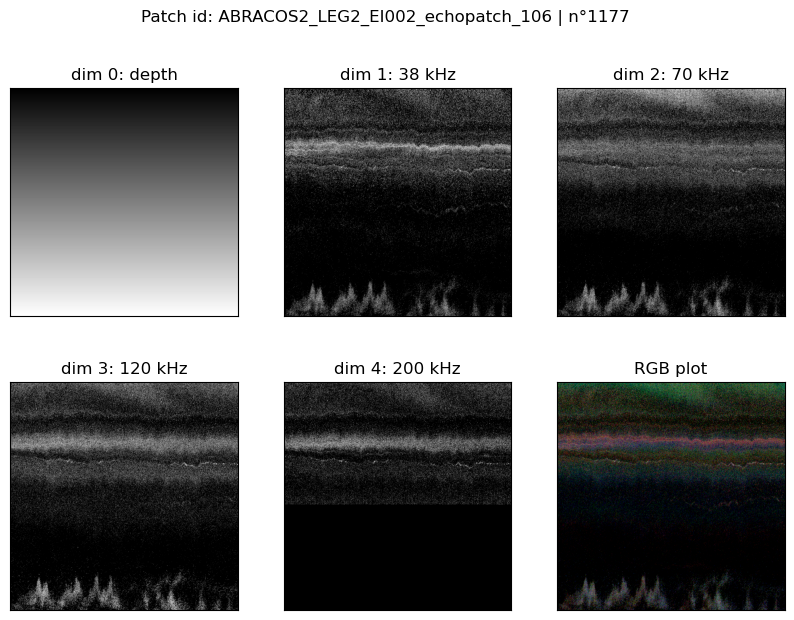

In [244]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

from src.visualization.visualize import add_mean, plot_patches

freqs = np.array([38, 70, 120, 200])

# catching a random echo patch from the dataset
id = random.randint(0, len(Dataset))
#id = 1327
id = 1177

print(f"Patch number {id}")

echo_name = Dataset.imagePaths[id].split("\\")[-1]
x, y = Dataset[id]

x = add_mean(x.unsqueeze(0), depth_dim=True).squeeze(0)
    
print(f"Shape: echo_tensor.shape")

# transoform to (0, 1)

# plot the first dimensions
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
s = 0
for i in range(2):
    for j in range(3-i):
        ax[i, j].imshow(np.array(x[s]), cmap="gist_gray")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        if s == 0:
            ax[i, j].set_title(f"dim {s}: depth")
        else:
            ax[i, j].set_title(f"dim {s}: {freqs[s-1]} kHz")
        s += 1 
        
# RGB plot from tensor echo
trans = torchvision.transforms.ToPILImage()
x_img = trans(x[1:4, :, :])
ax[1, -1].imshow(x_img)
ax[1, -1].set_xticks([])
ax[1, -1].set_yticks([])
ax[1, -1].set_title("RGB plot")

fig.suptitle(f"Patch id: {echo_name.split('.')[0]} | n°{id}")

#fig.savefig(f'C:/Users/Gaspard/Desktop/Etudes/2-X/Stage 3A - MARBEC/Production_2/{id}_dim_RGB.png')

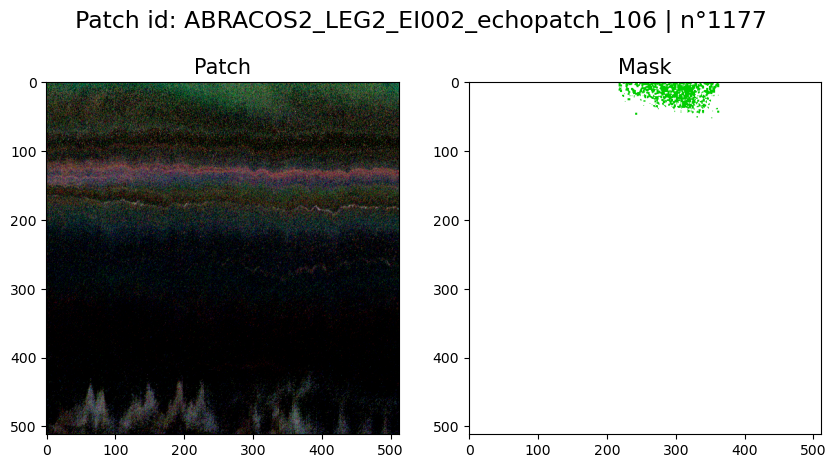

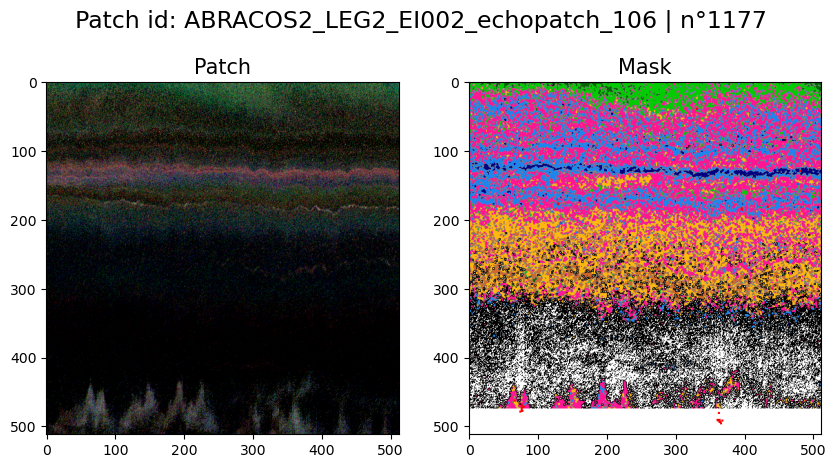

In [245]:
from src.visualization.visualize import plot_patches

color_list = np.array([(255,255,255), (0,0,0), (130,130,130), (0,0,128), (28,134,238), (255,21,147), (0,204,0), (0,100,0), (255,184,16), (209, 105, 44), (255, 0, 0)]) / 255

plot_patches(x[1:].unsqueeze(0), y.unsqueeze(0)+3, idx=[f"{echo_name.split('.')[0]} | n°{id}"], color_list=color_list)
#plt.savefig(f'C:/Users/Gaspard/Desktop/Etudes/2-X/Stage 3A - MARBEC/Production_2/{id}_echo_cluster.png')

_, y2 = Annotated_Dataset[id]

plot_patches(x[1:].unsqueeze(0), y2.unsqueeze(0)+3, idx=[f"{echo_name.split('.')[0]} | n°{id}"], color_list=color_list)

#plt.savefig(f'C:/Users/Gaspard/Desktop/Etudes/2-X/Stage 3A - MARBEC/Production_2/{id}_echo_mask.png')

## Permanent validation set

In [168]:
from sklearn.model_selection import train_test_split

print("Data directories from which to copy:")
print(f"    images_dir - {images_dir}")
print(f"    masks_dir - {masks_dir}")
print(f"    clusters_dir - {clusters_dir}")

# load the image and mask filepaths in a sorted manner
imagePaths = [os.path.join(images_dir, file_path) for file_path in sorted(os.listdir(images_dir))]
maskPaths = [os.path.join(masks_dir, file_path) for file_path in sorted(os.listdir(masks_dir))]
clusterPaths = [os.path.join(clusters_dir, file_path) for file_path in sorted(os.listdir(clusters_dir))]

y_paths = [(maskPaths[i], clusterPaths[i]) for i in range(len(maskPaths))]

# split data betweeen training and validation data
TRAIN_SIZE = 0.9

split = train_test_split(imagePaths,
                         y_paths,
                         train_size=TRAIN_SIZE,
                         random_state=42)



Data directories from which to copy:
    images_dir - D:\Stage_IRD_2023\semi_supervised_datasets_final\ABRACOS2_3F\dataset\echos
    masks_dir - D:\Stage_IRD_2023\semi_supervised_datasets_final\ABRACOS2_3F\dataset\masks
    clusters_dir - D:\Stage_IRD_2023\semi_supervised_datasets_final\ABRACOS2_3F\dataset\clusters_masks_wFISH


In [169]:
(trainImages, validImages) = split[:2]
(train_ys, valid_ys) = split[2:]

trainMasks, trainClusters = [c[0] for c in train_ys], [c[1] for c in train_ys]
validMasks, validClusters = [c[0] for c in valid_ys], [c[1] for c in valid_ys]

In [182]:
name = "test"
l = trainImages[0].split("\\")
l[3] += f"_{name}"
"\\".join(l)

'D:\\Stage_IRD_2023\\semi_supervised_datasets_final\\ABRACOS2_3F_test\\dataset\\echos\\ABRACOS2_LEG1_EI003_echopatch_86.npy'

In [192]:
import shutil
from tqdm import tqdm

def create_split_directories(Images, Masks, Clusters, name):
    for i in tqdm(range(len(Images))):
        # Images
        src = Images[i]
        l = src.split("\\")
        l[3] += f"_{name}"
        dst = "\\".join(l)
        shutil.copyfile(src, dst)
    
        # Masks
        src = Masks[i]
        l = src.split("\\")
        l[3] += f"_{name}"
        dst = "\\".join(l)
        shutil.copyfile(src, dst)
        
        # Clusters
        src = Clusters[i]
        l = src.split("\\")
        l[3] += f"_{name}"
        dst = "\\".join(l)
        shutil.copyfile(src, dst)
        
#create_split_directories(trainImages, trainMasks, trainClusters, name="train")
#create_split_directories(validImages, validMasks, validClusters, name="valid")

## Training and validation

In [2]:
import os
from pathlib import Path

import numpy as np
import torch
from tqdm import tqdm

# Set working directory
os.chdir("C:/Users/Gaspard/Desktop/Etudes/2-X/Stage 3A - MARBEC/echogram-segmentation")
print(f"Current working directory - {os.getcwd()}")

# Local imports
from src.utils.datasetup import SegmentationDataset, create_dataset, custom_sampler, assert_sampler
from src.builder.loss import semi_supervised_loss
import src.utils.transforms as segtrans
from src.builder.unet import UNet

# Hyperparameters
alpha = 0.03
BATCH_SIZE = 8
C = 10
centers = [[0.01875, 0.05625, -0.01875, -0.01875, -0.01875], [0, 0, 0, 0, 0]]
class_ids =  [-100, 0, 1, 2, 3, 4, 5, 6, 7]
DEPTH_DIM = False
dataset_name = "ABRACOS2_3F"
data_path = Path("D:/Stage_IRD_2023/semi_supervised_datasets_final")
forcing_alpha = 1
LEARNING_RATE = 1e-3
NUM_WORKERS = 0

# Setting device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Running on following device: {device}")

# Datasets creation
print("\n[INFO] Creating train and validation datasets")

# Set paths
train_data_path = data_path / (dataset_name + "_train") / "dataset"
valid_data_path = data_path / (dataset_name + "_valid") / "dataset"

# Set transforms
if DEPTH_DIM:
    transform = segtrans.Compose([
        segtrans.toZeroOne(max=-40., min=-80.),
        segtrans.ConvertDtype(image_dtype=torch.float32, target_dtype=torch.long),
        segtrans.CorrectClasses(),
        segtrans.MeanRes(depth_dim=DEPTH_DIM),
        segtrans.HorizontalFlip(p=0.5)
    ])
else: # remove channel 0
    transform = segtrans.Compose([
        segtrans.toZeroOne(max=-40., min=-80.),
        segtrans.ConvertDtype(image_dtype=torch.float32, target_dtype=torch.long),
        segtrans.CorrectClasses(),
        segtrans.Remove_channels([0]),
        segtrans.MeanRes(depth_dim=DEPTH_DIM),
        segtrans.HorizontalFlip(p=0.5)
    ])

trainSet, annotated_trainSet = create_dataset(train_data_path,
                                              transforms=transform)

validSet, annotated_validSet = create_dataset(valid_data_path,
                                              transforms=transform)
# /!\/!\/!\ 
trainSet = validSet

# Biases sampler creation
print("\n[INFO] Creating biased sampler")
train_sampler = custom_sampler(trainSet, class_ids, p=0.3) # add possibility to state random seed for replicability
assert_sampler(train_sampler, trainSet)

# Dataloaders creation
print("\n[INFO] Creating trainLoader")
trainLoader = torch.utils.data.DataLoader(dataset=trainSet,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS,
                                            sampler=train_sampler)

print("\n[INFO] Creating validLoader")
validLoader = torch.utils.data.DataLoader(dataset=validSet,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS,
                                            shuffle=False)

# Computing class frequencies and class weights
print("\n[INFO] Computing class weights")
x, _ = trainSet[0]
size = x.shape[-1]
n_samples = len(trainSet) * size**2

Y_tot = []
for _, (_, Y) in tqdm(enumerate(trainLoader)):
    Y_tot.append(Y)
Y_tot = torch.cat(Y_tot)

_, bincount = torch.unique(Y_tot, return_counts=True)
print(f"Bincount for all classes:\n{bincount}")

class_weights = n_samples / (C * bincount)
print(f"Class weights for balanced influence of each class:\n{class_weights}")

# Computing nummber of clusters per class
nb_clusters = np.zeros(8)
for _, (_, Y) in tqdm(enumerate(trainLoader)):
    for y in Y:
        for k in torch.unique(y)[1:]:
            nb_clusters[k] += 1
print(f"Number of clusters in the training set (with biased sampling): {nb_clusters}")

# Instanciating model
print("\n[INFO] Instanciating model")
model = UNet(enc_channels=[5, 16, 32],
             dec_channels=[32, 16],
             nb_classes=C,
             out_size=(512, 512))

# Creating a loss function and an optimizer
print("\n[INFO] Instanciating loss function and optimizer")
loss_fn = semi_supervised_loss(class_weights,
                               forcing_alpha=forcing_alpha,
                               alpha=alpha,
                               centers=centers,
                               device=device)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

Current working directory - C:\Users\Gaspard\Desktop\Etudes\2-X\Stage 3A - MARBEC\echogram-segmentation
[INFO] Running on following device: cpu

[INFO] Creating train and validation datasets

[INFO] Creating biased sampler


100%|██████████| 145/145 [00:05<00:00, 25.07it/s]



Creating biased sampler with 30.00% of annotated patches...
Sampler created.
Asserting sampler...


100%|██████████| 145/145 [00:01<00:00, 106.81it/s]



Proportion of annotated patches in sample over whole trainSet: 24.83

[INFO] Creating trainLoader

[INFO] Creating validLoader

[INFO] Computing class weights


19it [00:01, 13.39it/s]


Bincount for all classes:
tensor([37734006,    83660,    47632,   103017,    34926,     1348,     2237,
            4054])
Class weights for balanced influence of each class:
tensor([1.0073e-01, 4.5435e+01, 7.9801e+01, 3.6898e+01, 1.0883e+02, 2.8198e+03,
        1.6992e+03, 9.3761e+02])


19it [00:01, 14.02it/s]

Number of clusters in the training set (with biased sampling): [15. 14. 20.  4.  0.  1.  1.  6.]

[INFO] Instanciating model

[INFO] Instanciating loss function and optimizer


In [ ]:
from torch import nn

X, Y = next(iter(trainLoader))

softmax = nn.Softmax(dim=1)

print("Dummy model predictions...")
model.eval()
with torch.inference_mode():
    y_logits = model(X)
    y_preds = softmax(y_logits)
    
print("Loss computation...")
rfcm_loss, ce_loss, total_loss = loss_fn(y_preds, X, Y)
print(f"Unsupervised loss (RFCM + 2 forced centers): {rfcm_loss:.4f}\nSupervised loss (CE): {ce_loss:.4f}")
print(f"Total loss (unsup + {alpha}*sup): {total_loss:.4f}")

Dummy model predictions...
Loss computation...
Unsupervised loss (RFCM + 2 forced centers): 0.0898
Supervised loss (CE): 2.0608
Total loss (unsup + 0.03*sup): 0.1516


In [ ]:
from torch.utils.tensorboard import SummaryWriter

from src.engine.utils import train_step

softmax = torch.nn.Softmax(dim=1)

# Create a writer with all default settings
writer = SummaryWriter()
from src.engine.utils import train
          
train(model=model.to(device),
      out=softmax,
      train_dataloader=trainLoader,
      valid_dataloader=validLoader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=1,
      device=device,
      writer=writer)